### Алгоритмы классического ML с разными векторизаторами

### USE + SentenceTransformers

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

In [ ]:
from absl import logging

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Загрузка данных

In [ ]:
news_data = pd.read_csv('/content/drive/MyDrive/Data/NewsAgreggatorKaggleFNforBERT.csv')
news_data.head()

,title,label
0,supply demand chain executive oil falls to aro...,0
1,london south east major averages climb off low...,0
2,gabrielle cintorino new poll shows support for...,1
3,artist s impression of the clinton machine rus...,1
4,worcester telegram s p gains on global growth ...,0


In [ ]:
news_data.isnull().sum()

title    180
label      0
dtype: int64

In [ ]:
news_data = news_data.dropna()

In [ ]:
#separating the data and label
X = news_data['title'].values
Y = news_data['label'].values

In [ ]:
print(X)

['supply demand chain executive oil falls to around after china japan data'
 'london south east major averages climb off lows but remain in the red'
 'gabrielle cintorino new poll shows support for police officers is on the rise cop haters will be furious'
 ... 'bay news spacex preps falcon rocket for pre dawn launch sunday'
 'law subscription jos a bank men s wearhouse ink b merger deal'
 'hillary clinton laundered isis cash says investigating u s army officer']


#### Загрузка тестовых данных из другого датасета

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Data/FNDatasetBERT.csv')
test_data.head()

,title,label
0,wow sarcastic mike barnicle gets an earful fro...,1
1,beijing reuters china tightens control of chat...,0
2,orangeburg s c young blacks more open to berni...,0
3,washington reuters skeptical lawmakers pressur...,0
4,open borders advocate nancy pelosi gives gibbe...,1


In [ ]:
#separating the data and label
x_test = test_data['title'].values
y_test = test_data['label'].values

### Universal Sentence Encoder (USE)

In [ ]:
test_embeddings = embed(x_test)

In [ ]:
# Reduce logging output
# logging.set_verbosity(logging.ERROR)

news_embeddings = embed(X)

In [ ]:
news_embeddings.shape

TensorShape([24458, 512])

In [ ]:
embeddings = np.array(news_embeddings)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, Y, test_size = 0.2, stratify=Y, random_state=2)

In [ ]:
def roc_curve_plot(fpr, tpr, roc_auc, model_name, vectorizer_name):
    plt.figure(figsize=(5.5,4))
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC кривая (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}+{vectorizer_name}')
    plt.legend(loc="lower right")
    plt.show()

#### Logistic Regression + USE

In [ ]:
LogReg_model = LogisticRegression()

In [ ]:
LogReg_model.fit(X_train, Y_train)

LogisticRegression()

In [ ]:
X_train_prediction = LogReg_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of LogReg+USE on the training data : ', training_data_accuracy)

Accuracy score of LogReg+USE on the training data :  0.9139834406623735


In [ ]:
X_test_prediction = LogReg_model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of LogReg+USE on the testing data : ', test_data_accuracy)

Accuracy score of LogReg+USE on the testing data :  0.9116925592804579


In [ ]:
lr_probs = LogReg_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

In [ ]:
lr_auc = roc_auc_score(Y_test, lr_probs)
print('LogReg+USE: ROC AUC=%.3f' % (lr_auc))

LogReg+USE: ROC AUC=0.972


In [ ]:
lr_use_fpr, lr_use_tpr, treshold = roc_curve(Y_test, lr_probs)
lr_use_roc_auc = auc(lr_use_fpr, lr_use_tpr)

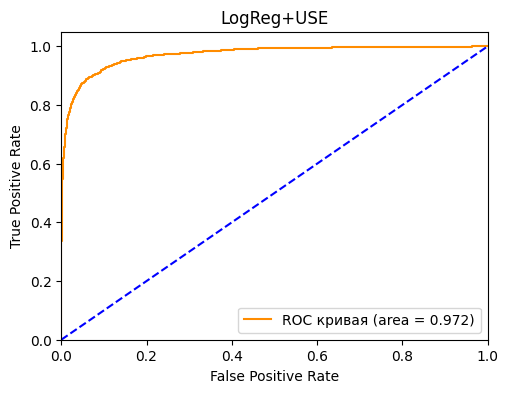

In [ ]:
roc_curve_plot(lr_use_fpr, lr_use_tpr, lr_use_roc_auc, 'LogReg', 'USE')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = LogReg_model.predict(test_embeddings)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

In [ ]:
print('Accuracy score of LogReg+USE on different testing data : ', test_data_accuracy)

Accuracy score of LogReg+USE on different testing data :  0.626865339213328


#### Naive Bayes + USE

In [ ]:
MB = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
MB.fit(X_train,Y_train) 

Pipeline(steps=[('Normalizing', MinMaxScaler()),
                ('MultinomialNB', MultinomialNB())])

In [ ]:
prediction = MB.predict(X_train)
test_data_accuracy = accuracy_score(prediction, Y_train)
print('Accuracy score of NB+USE on the training data: ', test_data_accuracy)

Accuracy score of NB+USE on the training data:  0.8411019114790964


In [ ]:
prediction = MB.predict(X_test)
score = metrics.accuracy_score(Y_test, prediction)
print('Accuracy score of NB+USE on the testing data: ', score)

Accuracy score of NB+USE on the testing data:  0.8444399018806215


In [ ]:
mb_probs = MB.predict_proba(X_test)
mb_probs = mb_probs[:, 1]

In [ ]:
mb_auc = roc_auc_score(Y_test, mb_probs)
print('MB+USE: ROC AUC=%.3f' % (mb_auc))

MB+USE: ROC AUC=0.928


In [ ]:
mb_use_fpr, mb_use_tpr, treshold = roc_curve(Y_test, mb_probs)
mb_use_roc_auc = auc(mb_use_fpr, mb_use_tpr)

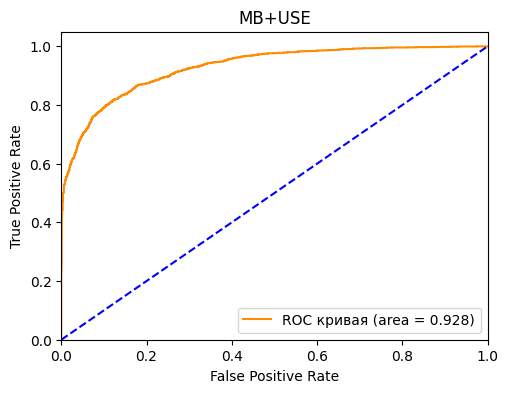

In [ ]:
roc_curve_plot(mb_use_fpr, mb_use_tpr, mb_use_roc_auc, 'MB', 'USE')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = MB.predict(test_embeddings)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

In [ ]:
print('Accuracy score of NB+USE on different testing data : ', test_data_accuracy)

Accuracy score of NB+USE on different testing data :  0.5725199340727872


#### SVM + USE

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto', probability=True)
SVM.fit(X_train,Y_train)
predictions_SVM = SVM.predict(X_train)
print('Accuracy score of SVM+USE on the training data: ', accuracy_score(predictions_SVM, Y_train))

Accuracy score of SVM+USE on the training data:  0.9214453644076459


In [ ]:
predictions_SVM = SVM.predict(X_test)
print('Accuracy score of SVM+USE on the testing data: ', accuracy_score(predictions_SVM, Y_test))

Accuracy score of SVM+USE on the testing data:  0.9213000817661489


In [ ]:
svm_probs = SVM.predict_proba(X_test)
svm_probs = svm_probs[:, 1]

In [ ]:
svm_auc = roc_auc_score(Y_test, svm_probs)
print('SVM+USE: ROC AUC=%.3f' % (svm_auc))

SVM+USE: ROC AUC=0.973


In [ ]:
svm_use_fpr, svm_use_tpr, treshold = roc_curve(Y_test, svm_probs)
svm_use_roc_auc = auc(svm_use_fpr, svm_use_tpr)

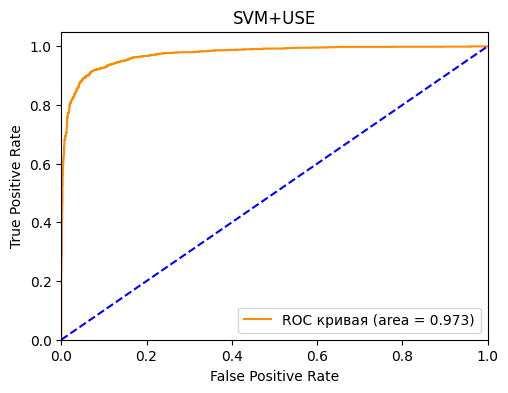

In [ ]:
roc_curve_plot(svm_use_fpr, svm_use_tpr, svm_use_roc_auc, 'SVM', 'USE')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = SVM.predict(test_embeddings)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

In [ ]:
print('Accuracy score of SVM+USE on different testing data : ', test_data_accuracy)

Accuracy score of SVM+USE on different testing data :  0.6500289545191322


### SentenceTransformers

In [ ]:
pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
embeddings = model.encode(X)

In [ ]:
embeddings.shape

(24458, 768)

In [ ]:
test_embeddings = model.encode(x_test)

In [ ]:
# np.save('BERT_news_embeddings_preprocessed.npy', embeddings)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, Y, test_size = 0.2, stratify=Y, random_state=2)

#### Logistic Regression + SentenceTransformers

In [ ]:
LogReg_model = LogisticRegression()

In [ ]:
LogReg_model.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
X_train_prediction = LogReg_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of LogReg+SentenceTransformers on the training data : ', training_data_accuracy)

Accuracy score of LogReg+SentenceTransformers on the training data :  0.9410712460390473


In [ ]:
X_test_prediction = LogReg_model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of LogReg+SentenceTransformers on the testing data : ', test_data_accuracy)

Accuracy score of LogReg+SentenceTransformers on the testing data :  0.9227309893704007


In [ ]:
lr_probs = LogReg_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

In [ ]:
lr_auc = roc_auc_score(Y_test, lr_probs)
print('LogReg+USE: ROC AUC=%.3f' % (lr_auc))

LogReg+USE: ROC AUC=0.976


In [ ]:
lr_st_fpr, lr_st_tpr, treshold = roc_curve(Y_test, lr_probs)
lr_st_roc_auc = auc(lr_st_fpr, lr_st_tpr)

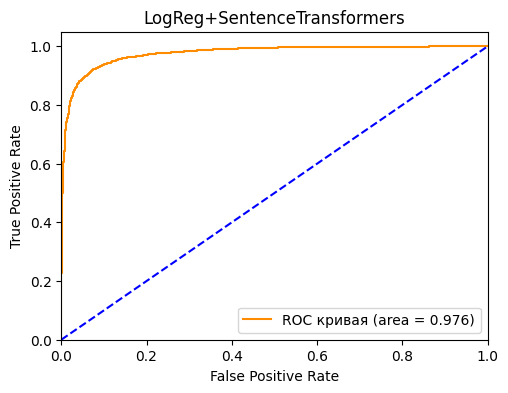

In [ ]:
roc_curve_plot(lr_st_fpr, lr_st_tpr, lr_st_roc_auc, 'LogReg', 'SentenceTransformers')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = LogReg_model.predict(test_embeddings)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

In [ ]:
print('Accuracy score of LogReg+SentenceTransformers on different testing data : ', test_data_accuracy)

Accuracy score of LogReg+SentenceTransformers on different testing data :  0.6428125974430933


#### Naive Bayes + SentenceTransformers

In [ ]:
MB=MultinomialNB()

In [ ]:
MB = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
MB.fit(X_train,Y_train) 

Pipeline(steps=[('Normalizing', MinMaxScaler()),
                ('MultinomialNB', MultinomialNB())])

In [ ]:
prediction = MB.predict(X_train)
test_data_accuracy = accuracy_score(prediction, Y_train)
print('Accuracy score of NB+SentenceTransformers on the training data: ', test_data_accuracy)

Accuracy score of NB+SentenceTransformers on the training data:  0.7610651129510375


In [ ]:
prediction = MB.predict(X_test)
score = metrics.accuracy_score(Y_test, prediction)
print('Accuracy score of NB+SentenceTransformers on the testing data: ', score)

Accuracy score of NB+SentenceTransformers on the testing data:  0.7555192150449714


In [ ]:
mb_probs = MB.predict_proba(X_test)
mb_probs = mb_probs[:, 1]

In [ ]:
mb_auc = roc_auc_score(Y_test, mb_probs)
print('MB+USE: ROC AUC=%.3f' % (mb_auc))

MB+USE: ROC AUC=0.847


In [ ]:
mb_st_fpr, mb_st_tpr, treshold = roc_curve(Y_test, mb_probs)
mb_st_roc_auc = auc(mb_st_fpr, mb_st_tpr)

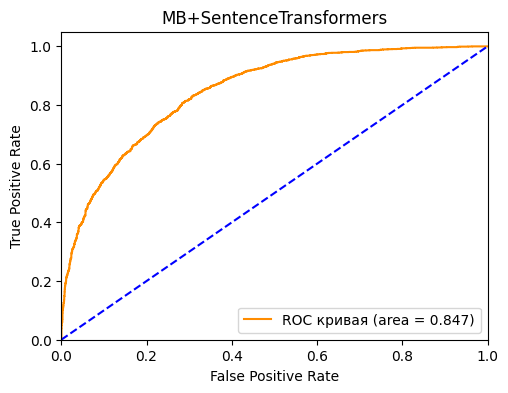

In [ ]:
roc_curve_plot(mb_st_fpr, mb_st_tpr, mb_st_roc_auc, 'MB', 'SentenceTransformers')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = MB.predict(test_embeddings)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

In [ ]:
print('Accuracy score of MB+SentenceTransformers on different testing data : ', test_data_accuracy)

Accuracy score of MB+SentenceTransformers on different testing data :  0.5901599180364382


#### SVM + SentenceTransformers

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto', probability=True)
SVM.fit(X_train,Y_train)
predictions_SVM = SVM.predict(X_train)
print('Accuracy score of SVM+SentenceTransformers on the training data: ', accuracy_score(predictions_SVM, Y_train))

Accuracy score of SVM+SentenceTransformers on the training data:  0.9442911172441991


In [ ]:
predictions_SVM = SVM.predict(X_test)
print('Accuracy score of SVM+SentenceTransformers on the testing data: ', accuracy_score(predictions_SVM, Y_test))

Accuracy score of SVM+SentenceTransformers on the testing data:  0.9202780049059689


In [ ]:
svm_probs = SVM.predict_proba(X_test)
svm_probs = svm_probs[:, 1]

In [ ]:
svm_auc = roc_auc_score(Y_test, svm_probs)
print('SVM+USE: ROC AUC=%.3f' % (svm_auc))

SVM+USE: ROC AUC=0.974


In [ ]:
svm_st_fpr, svm_st_tpr, treshold = roc_curve(Y_test, svm_probs)
svm_st_roc_auc = auc(svm_st_fpr, svm_st_tpr)

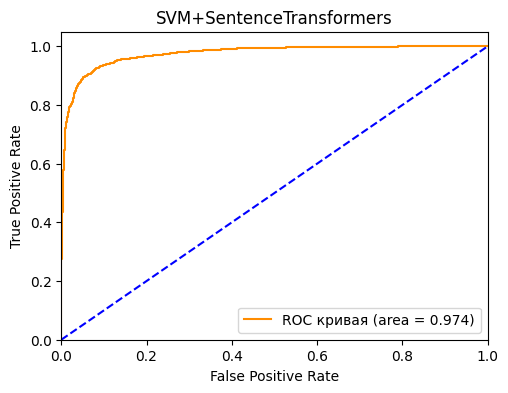

In [ ]:
roc_curve_plot(svm_st_fpr, svm_st_tpr, svm_st_roc_auc, 'SVM', 'SentenceTransformers')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = SVM.predict(test_embeddings)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

In [ ]:
print('Accuracy score of SVM+SentenceTransformers on different testing data : ', test_data_accuracy)

Accuracy score of SVM+SentenceTransformers on different testing data :  0.6453071406298722


#### ROC кривые для USE

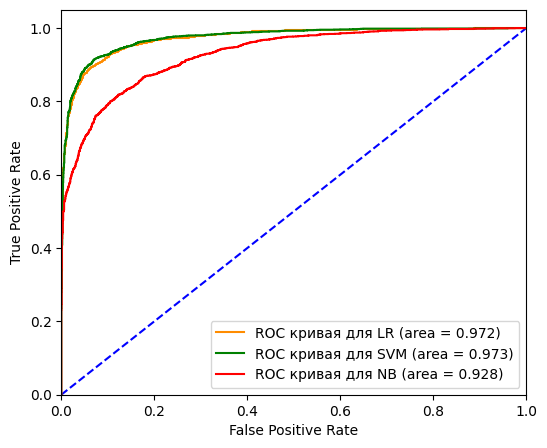

In [ ]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1],'b--')
plt.plot(lr_use_fpr, lr_use_tpr, color='darkorange', label='ROC кривая для LR (area = %0.3f)' % lr_use_roc_auc)
plt.plot(svm_use_fpr, svm_use_tpr, color='green', label='ROC кривая для SVM (area = %0.3f)' % svm_use_roc_auc)
plt.plot(mb_use_fpr, mb_use_tpr, color='red', label='ROC кривая для NB (area = %0.3f)' % mb_use_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### ROC кривые для SentenceTransformers

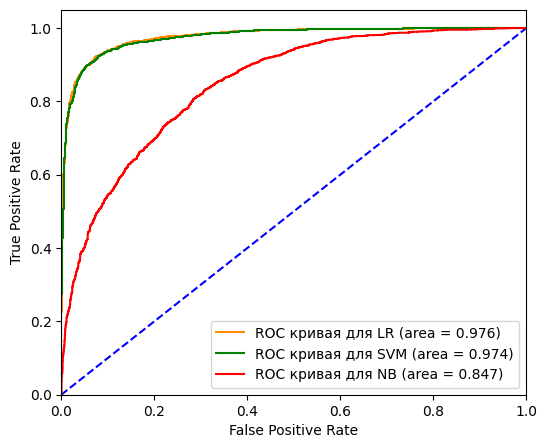

In [ ]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1],'b--')
plt.plot(lr_st_fpr, lr_st_tpr, color='darkorange', label='ROC кривая для LR (area = %0.3f)' % lr_st_roc_auc)
plt.plot(svm_st_fpr, svm_st_tpr, color='green', label='ROC кривая для SVM (area = %0.3f)' % svm_st_roc_auc)
plt.plot(mb_st_fpr, mb_st_tpr, color='red', label='ROC кривая для NB (area = %0.3f)' % mb_st_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Word2Vec + TF-IDF

#### Загрузка предобработанных данных

In [ ]:
news_data = pd.read_csv('drive/MyDrive/Data/NewsAgreggatorKaggleFN.csv')

In [ ]:
news_data.head()

,title,label
0,suppli demand chain execut oil fall around chi...,0
1,london south east major averag climb low remai...,0
2,gabriel cintorino new poll show support polic ...,1
3,artist impress clinton machin russia news,1
4,worcest telegram p gain global growth prospect,0


In [ ]:
news_data.isnull().sum()

title    180
label      0
dtype: int64

In [ ]:
news_data = news_data.dropna()

In [ ]:
news_data.isnull().sum()

title    0
label    0
dtype: int64

In [ ]:
#separating the data and label
X = news_data['title'].values
Y = news_data['label'].values

In [ ]:
print(X)

['suppli demand chain execut oil fall around china japan data'
 'london south east major averag climb low remain red'
 'gabriel cintorino new poll show support polic offic rise cop hater furiou'
 ... 'bay news spacex prep falcon rocket pre dawn launch sunday'
 'law subscript jo bank men wearhous ink b merger deal'
 'hillari clinton launder isi cash say investig u armi offic']


In [ ]:
print(Y)

[0 0 1 ... 0 0 1]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2, stratify=Y)

### Word2Vec 

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(vector_size=300, min_count=1)

In [ ]:
cleaned_data=[]
for sent in X_train:
    cleaned_data.append(str(sent).split()) 

In [ ]:
cleaned_data[1]

['admin', 'watch', 'israel', 'help', 'build', 'techno', 'citi', 'kenya']

In [ ]:
w2v_model.build_vocab(cleaned_data)

In [ ]:
w2v_model.train(cleaned_data, total_examples=w2v_model.corpus_count, epochs=30)

(5235522, 5385060)

In [ ]:
w2v_model.wv.most_similar('car')

[('afterward', 0.7295617461204529),
 ('mustang', 0.729408323764801),
 ('bangalor', 0.7214296460151672),
 ('crash', 0.7149972319602966),
 ('faulti', 0.7147430777549744),
 ('vehicl', 0.7097336649894714),
 ('deadli', 0.7055781483650208),
 ('brake', 0.697882354259491),
 ('ignit', 0.6870474219322205),
 ('loaner', 0.6850637793540955)]

In [ ]:
w2v_model.wv.most_similar('putin')

[('avert', 0.7407204508781433),
 ('vladimir', 0.7389823198318481),
 ('dutert', 0.7197902202606201),
 ('neocon', 0.7128280997276306),
 ('khodorkovski', 0.7040077447891235),
 ('provok', 0.7017760872840881),
 ('tass', 0.6948691606521606),
 ('saker', 0.6901693940162659),
 ('russia', 0.6810259222984314),
 ('patrushev', 0.6796718835830688)]

In [ ]:
def Word2Vectorizer(data,model,size):
    vectors = []
    for sent in data:
        sent_vec = np.zeros(size)
        cnt_words = 0
        for word in sent:
            try:
                vec = model.wv[word]  # getting the vector corresponding to the word
                sent_vec += vec       # Adding the vectors of all the words present in sentence
                cnt_words += 1        # counting the number of words
            except:
                pass
        if cnt_words!=0:    
            sent_vec /= cnt_words
        vectors.append(sent_vec)
    return np.nan_to_num(vectors)

In [ ]:
cleaned_test_data=[]
for sent in X_test:
    cleaned_test_data.append(str(sent).split()) 

In [ ]:
train_data_w2v=Word2Vectorizer(cleaned_data,w2v_model,300)
test_data_w2v=Word2Vectorizer(cleaned_test_data,w2v_model,300)

In [ ]:
print(test_data_w2v)

[[-0.12849122  0.31077979 -0.2172426  ... -0.17089851  0.04926763
   0.27620397]
 [-0.27464725  0.43902502  0.29370622 ... -0.08211996  0.24915176
   0.20776038]
 [ 0.11944779  0.03941106  0.09239595 ... -0.57057866 -0.30892271
   0.37289254]
 ...
 [ 0.10956093  0.45093037 -0.12185343 ... -0.06432326 -0.06459256
  -0.1969903 ]
 [-0.3274061   0.30819266  0.01822171 ... -0.03579248  0.43217806
   0.07637097]
 [ 0.03556704  0.00723101 -0.02272523 ... -0.1392313   0.13017763
   0.16847733]]


### TF-IDF

In [ ]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer()

In [ ]:
train_data_tfidf = vectorizer.transform(X_train)
test_data_tfidf = vectorizer.transform(X_test)

#### Загрузка предобработанных тестовых данных

In [ ]:
test_data = pd.read_csv('drive/MyDrive/Data/FNDataset.csv')

In [ ]:
test_data.head()

,title,label
0,washington reuter white hous say iran progress...,0
1,washington reuter senat republican leader want...,0
2,break video hillari support blacklivesmatt act...,1
3,wow sara huckabe sander drop mother verbal bom...,1
4,futur belong ai whoever master first rule world,1


In [ ]:
x_test = test_data['title'].values
y_test = test_data['label'].values

In [ ]:
x_test

array(['washington reuter white hous say iran progress nuclear deal must verifi',
       'washington reuter senat republican leader want health bill revis friday cornyn',
       'break video hillari support blacklivesmatt activist vandal trump brand new dc hotel video',
       ..., 'mural gov lepag wear kkk garb main citi uproar imag',
       'drive place worship london imam take presid trump advic refus perform funer right islam terrorist video',
       'wow fan break nfl jersey sale record time afghan war vet brave stood alon nation anthem claim stand mistak'],
      dtype=object)

#### Logistic Regression

In [ ]:
LR = LogisticRegression()

#### Logistic Regression + W2V

In [ ]:
LR.fit(train_data_w2v, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
X_train_prediction = LR.predict(train_data_w2v)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of LogReg+W2V on the training data : ', training_data_accuracy)

Accuracy score of LogReg+W2V on the training data :  0.9584994378002658


In [ ]:
X_test_prediction = LR.predict(test_data_w2v)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of LogReg+W2V on the testing data : ', test_data_accuracy)

Accuracy score of LogReg+W2V on the testing data :  0.9578904333605888


In [ ]:
lr_probs = LR.predict_proba(test_data_w2v)
lr_probs = lr_probs[:, 1]

In [ ]:
lr_auc = roc_auc_score(Y_test, lr_probs)
print('LogReg+Word2Vec: ROC AUC=%.3f' % (lr_auc))

LogReg+Word2Vec: ROC AUC=0.991


In [ ]:
lr_w2v_fpr, lr_w2v_tpr, treshold = roc_curve(Y_test, lr_probs)
lr_w2v_roc_auc = auc(lr_w2v_fpr, lr_w2v_tpr)

In [ ]:
def roc_curve_plot(fpr, tpr, roc_auc, model_name, vectorizer_name):
    plt.figure(figsize=(5.5,4))
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC кривая (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}+{vectorizer_name}')
    plt.legend(loc="lower right")
    plt.show()

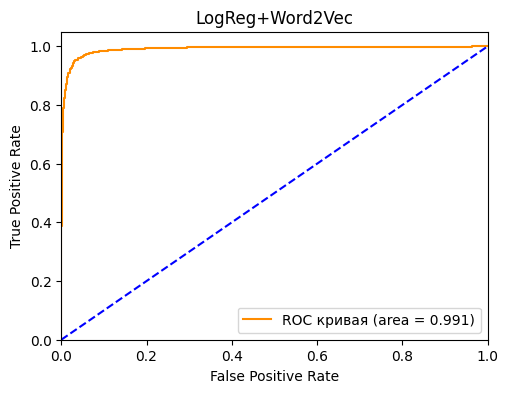

In [ ]:
roc_curve_plot(lr_w2v_fpr, lr_w2v_tpr, lr_w2v_roc_auc, 'LogReg', 'Word2Vec')

#### Тестирование на другом датасете

In [ ]:
cleaned_test_data=[]
for sent in x_test:
    cleaned_test_data.append(str(sent).split()) 

cleaned_test_data[1]

['washington',
 'reuter',
 'senat',
 'republican',
 'leader',
 'want',
 'health',
 'bill',
 'revis',
 'friday',
 'cornyn']

In [ ]:
data_w2v_test=Word2Vectorizer(cleaned_test_data,w2v_model,300)

In [ ]:
x_test_prediction = LR.predict(data_w2v_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print('Accuracy score of LogReg+W2V on different testing data : ', test_data_accuracy)

Accuracy score of LogReg+W2V on different testing data :  0.6408748719319346


#### Logistic Regression + TF-IDF

In [ ]:
LR.fit(train_data_tfidf, Y_train)

LogisticRegression()

In [ ]:
X_train_prediction = LR.predict(train_data_tfidf)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of LogReg+TF-IDF on the training data : ', training_data_accuracy)

Accuracy score of LogReg+TF-IDF on the training data :  0.9887560053153429


In [ ]:
X_test_prediction = LR.predict(test_data_tfidf)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of LogReg+TF-IDF on the testing data : ', test_data_accuracy)

Accuracy score of LogReg+TF-IDF on the testing data :  0.9764922322158627


In [ ]:
lr_probs = LR.predict_proba(test_data_tfidf)
lr_probs = lr_probs[:, 1]

In [ ]:
lr_auc = roc_auc_score(Y_test, lr_probs)
print('LogReg+TF-IDF: ROC AUC=%.3f' % (lr_auc))

LogReg+TF-IDF: ROC AUC=0.997


In [ ]:
lr_tfidf_fpr, lr_tfidf_tpr, treshold = roc_curve(Y_test, lr_probs)
lr_tfidf_roc_auc = auc(lr_tfidf_fpr, lr_tfidf_tpr)

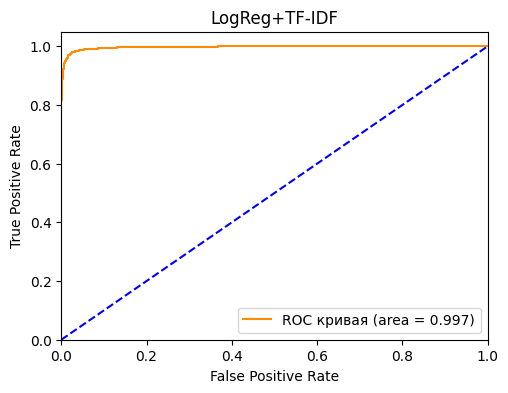

In [ ]:
roc_curve_plot(lr_tfidf_fpr, lr_tfidf_tpr, lr_tfidf_roc_auc, 'LogReg', 'TF-IDF')

#### Тестирование на другом датасете

In [ ]:
data_test_tfidf = vectorizer.transform(x_test)

In [ ]:
x_test_prediction = LR.predict(data_test_tfidf)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print('Accuracy score of LogReg+TF-IDF on different testing data : ', test_data_accuracy)

Accuracy score of LogReg+TF-IDF on different testing data :  0.6470221390707827


#### MULTINOMIAL NAIVE BAYES

#### NAIVE BAYES + W2V

In [ ]:
MB = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
MB.fit(train_data_w2v,Y_train) 

Pipeline(steps=[('Normalizing', MinMaxScaler()),
                ('MultinomialNB', MultinomialNB())])

In [ ]:
prediction = MB.predict(train_data_w2v)
test_data_accuracy = accuracy_score(prediction, Y_train)
print('Accuracy score of NB+W2V on the training data: ', test_data_accuracy)

Accuracy score of NB+W2V on the training data:  0.9377491567003986


In [ ]:
prediction = MB.predict(test_data_w2v)
score = metrics.accuracy_score(Y_test, prediction)
print('Accuracy score of NB+W2V on the testing data: ', score)

Accuracy score of NB+W2V on the testing data:  0.9413327882256746


In [ ]:
nb_probs = MB.predict_proba(test_data_w2v)
nb_probs = nb_probs[:, 1]

In [ ]:
nb_auc = roc_auc_score(Y_test, nb_probs)
print('NB+Word2Vec: ROC AUC=%.3f' % (nb_auc))

NB+Word2Vec: ROC AUC=0.985


In [ ]:
nb_w2v_fpr, nb_w2v_tpr, treshold = roc_curve(Y_test, nb_probs)
nb_w2v_roc_auc = auc(nb_w2v_fpr, nb_w2v_tpr)

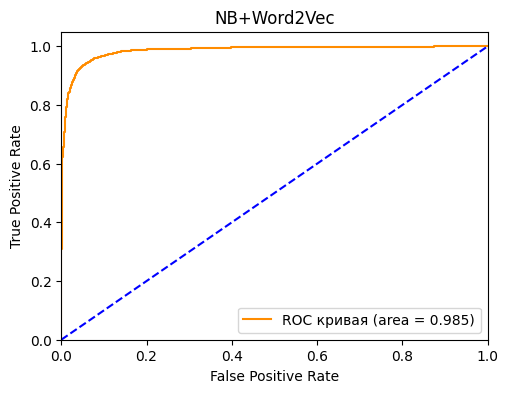

In [ ]:
roc_curve_plot(nb_w2v_fpr, nb_w2v_tpr, nb_w2v_roc_auc, 'NB', 'Word2Vec')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = MB.predict(data_w2v_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print('Accuracy score of MB+W2V on different testing data : ', test_data_accuracy)

Accuracy score of MB+W2V on different testing data :  0.6103167178938929


#### NAIVE BAYES + TF-IDF

In [ ]:
MB = Pipeline([('Normalizing',MaxAbsScaler()),('MultinomialNB',MultinomialNB())])
MB.fit(train_data_tfidf, Y_train)

Pipeline(steps=[('Normalizing', MaxAbsScaler()),
                ('MultinomialNB', MultinomialNB())])

In [ ]:
prediction = MB.predict(train_data_tfidf)
test_data_accuracy = accuracy_score(prediction, Y_train)
print('Accuracy score of NB+TF-IDF on the training data: ', test_data_accuracy)

Accuracy score of NB+TF-IDF on the training data:  0.9876827149136257


In [ ]:
prediction = MB.predict(test_data_tfidf)
score = metrics.accuracy_score(Y_test, prediction)
print('Accuracy score of NB+TF-IDF on the testing data: ', score)

Accuracy score of NB+TF-IDF on the testing data:  0.9775143090760425


In [ ]:
nb_probs = MB.predict_proba(test_data_tfidf)
nb_probs = nb_probs[:, 1]

In [ ]:
nb_auc = roc_auc_score(Y_test, nb_probs)
print('NB+TF-IDF: ROC AUC=%.3f' % (nb_auc))

NB+TF-IDF: ROC AUC=0.998


In [ ]:
nb_tfidf_fpr, nb_tfidf_tpr, treshold = roc_curve(Y_test, nb_probs)
nb_tfidf_roc_auc = auc(nb_tfidf_fpr, nb_tfidf_tpr)

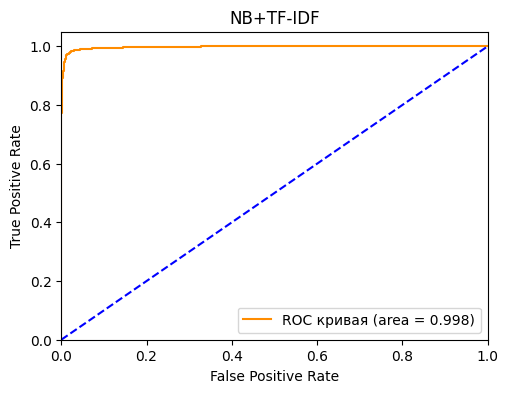

In [ ]:
roc_curve_plot(nb_tfidf_fpr, nb_tfidf_tpr, nb_tfidf_roc_auc, 'NB', 'TF-IDF')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = MB.predict(data_test_tfidf)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print('Accuracy score of MB+TF-IDF on different testing data : ', test_data_accuracy)

Accuracy score of MB+TF-IDF on different testing data :  0.6331907880083746


#### SUPPORT VECTOR MACHINES

#### SVM + W2V

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto', probability=True)
SVM.fit(train_data_w2v,Y_train)
predictions_SVM = SVM.predict(train_data_w2v)
print('Accuracy score of SVM+W2V on the training data: ', accuracy_score(predictions_SVM, Y_train))

Accuracy score of SVM+W2V on the training data:  0.9607482367371972


In [ ]:
predictions_SVM = SVM.predict(test_data_w2v)
print('Accuracy score of SVM+W2V on the testing data: ', accuracy_score(predictions_SVM, Y_test))

Accuracy score of SVM+W2V on the testing data:  0.9593213409648406


In [ ]:
svm_probs = SVM.predict_proba(test_data_w2v)
svm_probs = svm_probs[:, 1]

In [ ]:
svm_auc = roc_auc_score(Y_test, svm_probs)
print('SVM+Word2Vec: ROC AUC=%.3f' % (svm_auc))

SVM+Word2Vec: ROC AUC=0.991


In [ ]:
svm_w2v_fpr, svm_w2v_tpr, treshold = roc_curve(Y_test, svm_probs)
svm_w2v_roc_auc = auc(svm_w2v_fpr, svm_w2v_tpr)

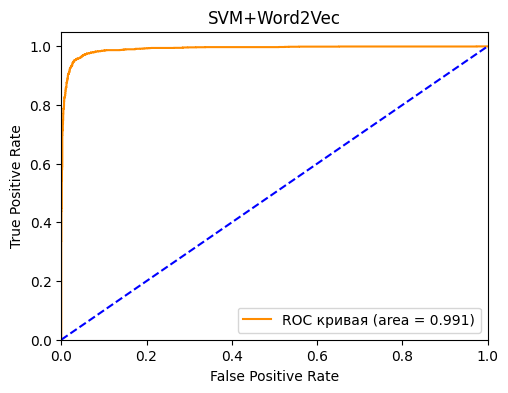

In [ ]:
roc_curve_plot(svm_w2v_fpr, svm_w2v_tpr, svm_w2v_roc_auc, 'SVM', 'Word2Vec')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = SVM.predict(data_w2v_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print('Accuracy score of SVM+W2V on different testing data : ', test_data_accuracy)

Accuracy score of SVM+W2V on different testing data :  0.6585148558955856


#### SVM + TF-IDF

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto', probability=True)
SVM.fit(train_data_tfidf,Y_train)
predictions_SVM = SVM.predict(train_data_tfidf)
print('Accuracy score of SVM+TF-IDF on the training data: ', accuracy_score(predictions_SVM, Y_train))

Accuracy score of SVM+TF-IDF on the training data:  0.9962179290606153


In [ ]:
predictions_SVM = SVM.predict(test_data_tfidf)
print('Accuracy score of SVM+TF-IDF on the testing data: ', accuracy_score(predictions_SVM, Y_test))

Accuracy score of SVM+TF-IDF on the testing data:  0.981807031888798


In [ ]:
svm_probs = SVM.predict_proba(test_data_tfidf)
svm_probs = svm_probs[:, 1]

In [ ]:
svm_auc = roc_auc_score(Y_test, svm_probs)
print('SVM+Word2Vec: ROC AUC=%.3f' % (svm_auc))

SVM+Word2Vec: ROC AUC=0.998


In [ ]:
svm_tfidf_fpr, svm_tfidf_tpr, treshold = roc_curve(Y_test, svm_probs)
svm_tfidf_roc_auc = auc(svm_tfidf_fpr, svm_tfidf_tpr)

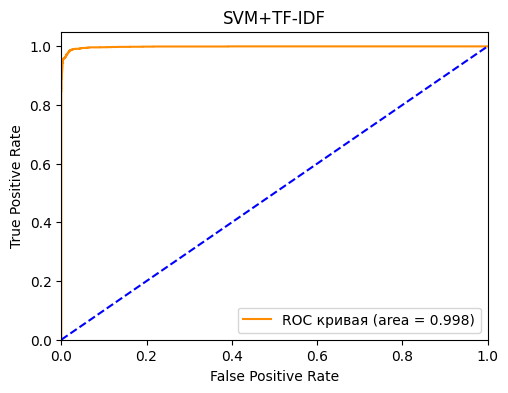

In [ ]:
roc_curve_plot(svm_tfidf_fpr, svm_tfidf_tpr, svm_tfidf_roc_auc, 'SVM', 'TF-IDF')

#### Тестирование на другом датасете

In [ ]:
x_test_prediction = SVM.predict(data_test_tfidf)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print('Accuracy score of SVM+TF-IDF on different testing data : ', test_data_accuracy)

Accuracy score of SVM+TF-IDF on different testing data :  0.6551739498418638


In [ ]:
np.save('drive/MyDrive/NPY/svm_use_tpr.npy', svm_use_tpr)
np.save('drive/MyDrive/NPY/svm_use_fpr.npy', svm_use_fpr)
np.save('drive/MyDrive/NPY/svm_st_fpr.npy', svm_st_fpr)
np.save('drive/MyDrive/NPY/svm_st_tpr.npy', svm_use_tpr)

#### ROC кривые

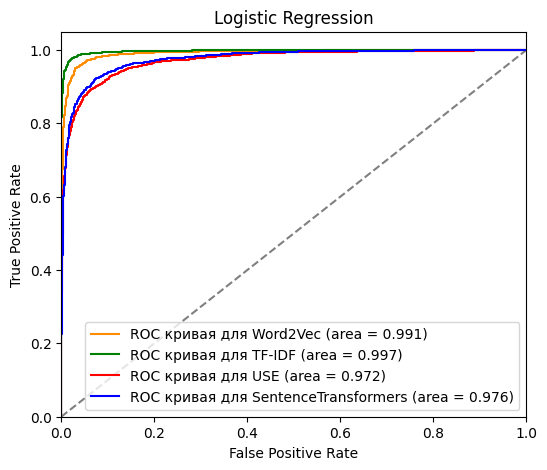

In [ ]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(lr_w2v_fpr, lr_w2v_tpr, color='darkorange', label='ROC кривая для Word2Vec (area = %0.3f)' % lr_w2v_roc_auc)
plt.plot(lr_tfidf_fpr, lr_tfidf_tpr, color='green', label='ROC кривая для TF-IDF (area = %0.3f)' % lr_tfidf_roc_auc)
plt.plot(lr_use_fpr, lr_use_tpr, color='red', label='ROC кривая для USE (area = %0.3f)' % lr_use_roc_auc)
plt.plot(lr_st_fpr, lr_st_tpr, color='blue', label='ROC кривая для SentenceTransformers (area = %0.3f)' % lr_st_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

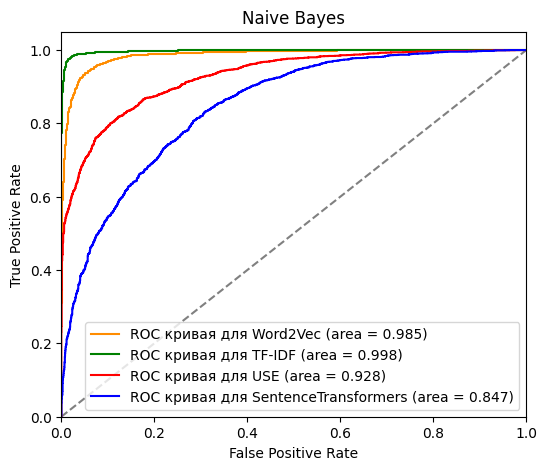

In [ ]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(nb_w2v_fpr, nb_w2v_tpr, color='darkorange', label='ROC кривая для Word2Vec (area = %0.3f)' % nb_w2v_roc_auc)
plt.plot(nb_tfidf_fpr, nb_tfidf_tpr, color='green', label='ROC кривая для TF-IDF (area = %0.3f)' % nb_tfidf_roc_auc)
plt.plot(mb_use_fpr, mb_use_tpr, color='red', label='ROC кривая для USE (area = %0.3f)' % mb_use_roc_auc)
plt.plot(mb_st_fpr, mb_st_tpr, color='blue', label='ROC кривая для SentenceTransformers (area = %0.3f)' % mb_st_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Naive Bayes")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

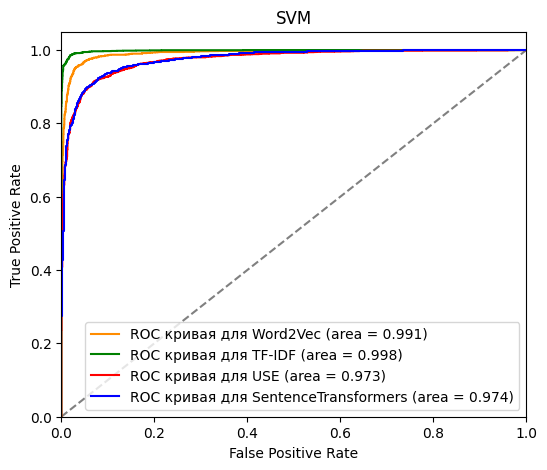

In [ ]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(svm_w2v_fpr, svm_w2v_tpr, color='darkorange', label='ROC кривая для Word2Vec (area = %0.3f)' % svm_w2v_roc_auc)
plt.plot(svm_tfidf_fpr, svm_tfidf_tpr, color='green', label='ROC кривая для TF-IDF (area = %0.3f)' % svm_tfidf_roc_auc)
plt.plot(svm_use_fpr, svm_use_tpr, color='red', label='ROC кривая для USE (area = %0.3f)' % svm_use_roc_auc)
plt.plot(svm_st_fpr, svm_st_tpr, color='blue', label='ROC кривая для SentenceTransformers (area = %0.3f)' % svm_st_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("SVM")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()